In [39]:
# from  lunarLanding import DQNAgent

%matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Dropout, Activation, Input, concatenate, add
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

import pylab as pl
from IPython import display


import itertools
import gym

import numpy as np
from scipy.special import softmax
import random
from sklearn import preprocessing
import matplotlib.pyplot as plt
import time

import os

['/job:localhost/replica:0/task:0/device:GPU:0']


In [105]:
import random
import gym
import numpy as np
from collections import deque
from scipy.special import softmax
import random
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.models import Sequential
import time

import os

# Deep Q-learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size, memsize = 7000, ga = 0.95, explore_rate = 1, explore_decay = 0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen = memsize)
        self.gamma = ga    # discount rate
        self.epsilon = explore_rate  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = explore_decay
        self.target_model = Sequential()
        self.engine_model = Sequential()

    def remember(self, state, action, reward, next_state, done):
        if not done:
            self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
                
        if np.random.rand() <= self.epsilon:
            chose = np.random.randint(0,4)
            return chose
        
        ACTION_SIZE = 4
        STATE_SIZE = 8
        bestStep = 0
        initialStep = np_utils.to_categorical(0, ACTION_SIZE).reshape(1, ACTION_SIZE)
        best_reward = self.target_model.predict([state.reshape(1, STATE_SIZE), initialStep])
        for action in range(1, ACTION_SIZE):
            step = np_utils.to_categorical(action, ACTION_SIZE).reshape(1, ACTION_SIZE)
            predict = self.target_model.predict([state.reshape(1, STATE_SIZE), step])
            if(predict > best_reward):
                bestStep = action
                best_reward = predict
                
        return bestStep
#     def replay(self, batch_size):
#         minibatch = random.sample(self.memory, batch_size)
#         xs = []
#         ys = []

#         for state, action, reward, next_state, done in minibatch:
#             target = reward

#             if not done:
#                 target = reward + np.multiply (self.gamma , self.model.predict(next_state)[0] )
#             else:
#                 target = np.multiply (self.gamma , self.model.predict(next_state)[0] )
                
#             xs.append(state[0])
#             ys.append(target)
#         xs = np.array(xs)
#         ys = np.array(ys)
#         self.model.fit(xs, ys, epochs= 1, verbose=0 , batch_size=batch_size)
                
#         if self.epsilon > self.epsilon_min:
#             self.epsilon *= self.epsilon_decay
    
    def save_model(self, model_name = './checkpoint.h5', mem_name = 'memory'):
        self.target_model.save(model_name)

    def load_model(self,  model_name = './checkpoint.h5' , mem_name = 'memory.npy'):
        self.target_model.load_weights(model_name)
        self.engine_model.load_weights(model_name)
        self.memory = np.load(mem_name, allow_pickle=True)
        self.memory = deque(self.memory)
    def learn (self):
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay** 10
        output = list(itertools.islice(agent.memory, 0, None))
        xs_state = []
        xs_action = []
        ys = []
        for i in output:
            ys.append(i[2])
#             print('reward',i[2])
            step = np_utils.to_categorical(i[1], 4).reshape(1, 4)

            xs_state.append(i[0][0])
            xs_action.append(step)

        ys = np.array(ys)
        lgn = len(xs_state)
        xs_action = np.array(xs_action).reshape(lgn, 4)
#         print(xs.shape)
        self.engine_model.fit([xs_state, xs_action], ys, epochs = 4 , verbose = 1)
        del self.memory
        
        self.memory = deque(maxlen = 9000)
#         print(len(self.memory))
        self.engine_model.save_weights("checkpoint.h5")
        self.target_model.set_weights(self.engine_model.get_weights()) 

In [103]:
input_state = Input(shape=(8,))
input_action = Input(shape=(4,))

m = Dense(64)(input_state)
m = BatchNormalization()(m)

m = Dense(64, activation='relu')(m)
m = BatchNormalization()(m)

m = Dense(64, activation='relu')(m)
m = BatchNormalization()(m)

# m = Model(inputs = input_state, outputs = m)

#####

m_i = Dense(32,activation='relu')(input_action)
m_i = BatchNormalization()(m_i)

m_i = Dense(32,activation='relu')(m_i)
m_i = BatchNormalization()(m_i)

m_i = Dense(32,activation='relu')(m_i)
m_i = BatchNormalization()(m_i)

# m_i = Model(inputs = input_action, outputs = m_i)

u = concatenate([m,m_i])

u = Dense(64, activation='relu')(u)
u = BatchNormalization()(u)

u = Dense(32, activation='relu')(u)
u = BatchNormalization()(u)

u = Dense(1)(u)

u = Model(inputs= [input_state,input_action ], outputs = u)

u.compile(loss='mse', optimizer=Adam())
u.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
input_48 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
dense_208 (Dense)               (None, 64)           576         input_47[0][0]                   
__________________________________________________________________________________________________
dense_211 (Dense)               (None, 32)           160         input_48[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [106]:
env = gym.make('LunarLander-v2')
state_size = 8
action_size = 4
agent = DQNAgent(state_size, action_size, memsize= 9000)

agent.target_model = u
agent.engine_model = u

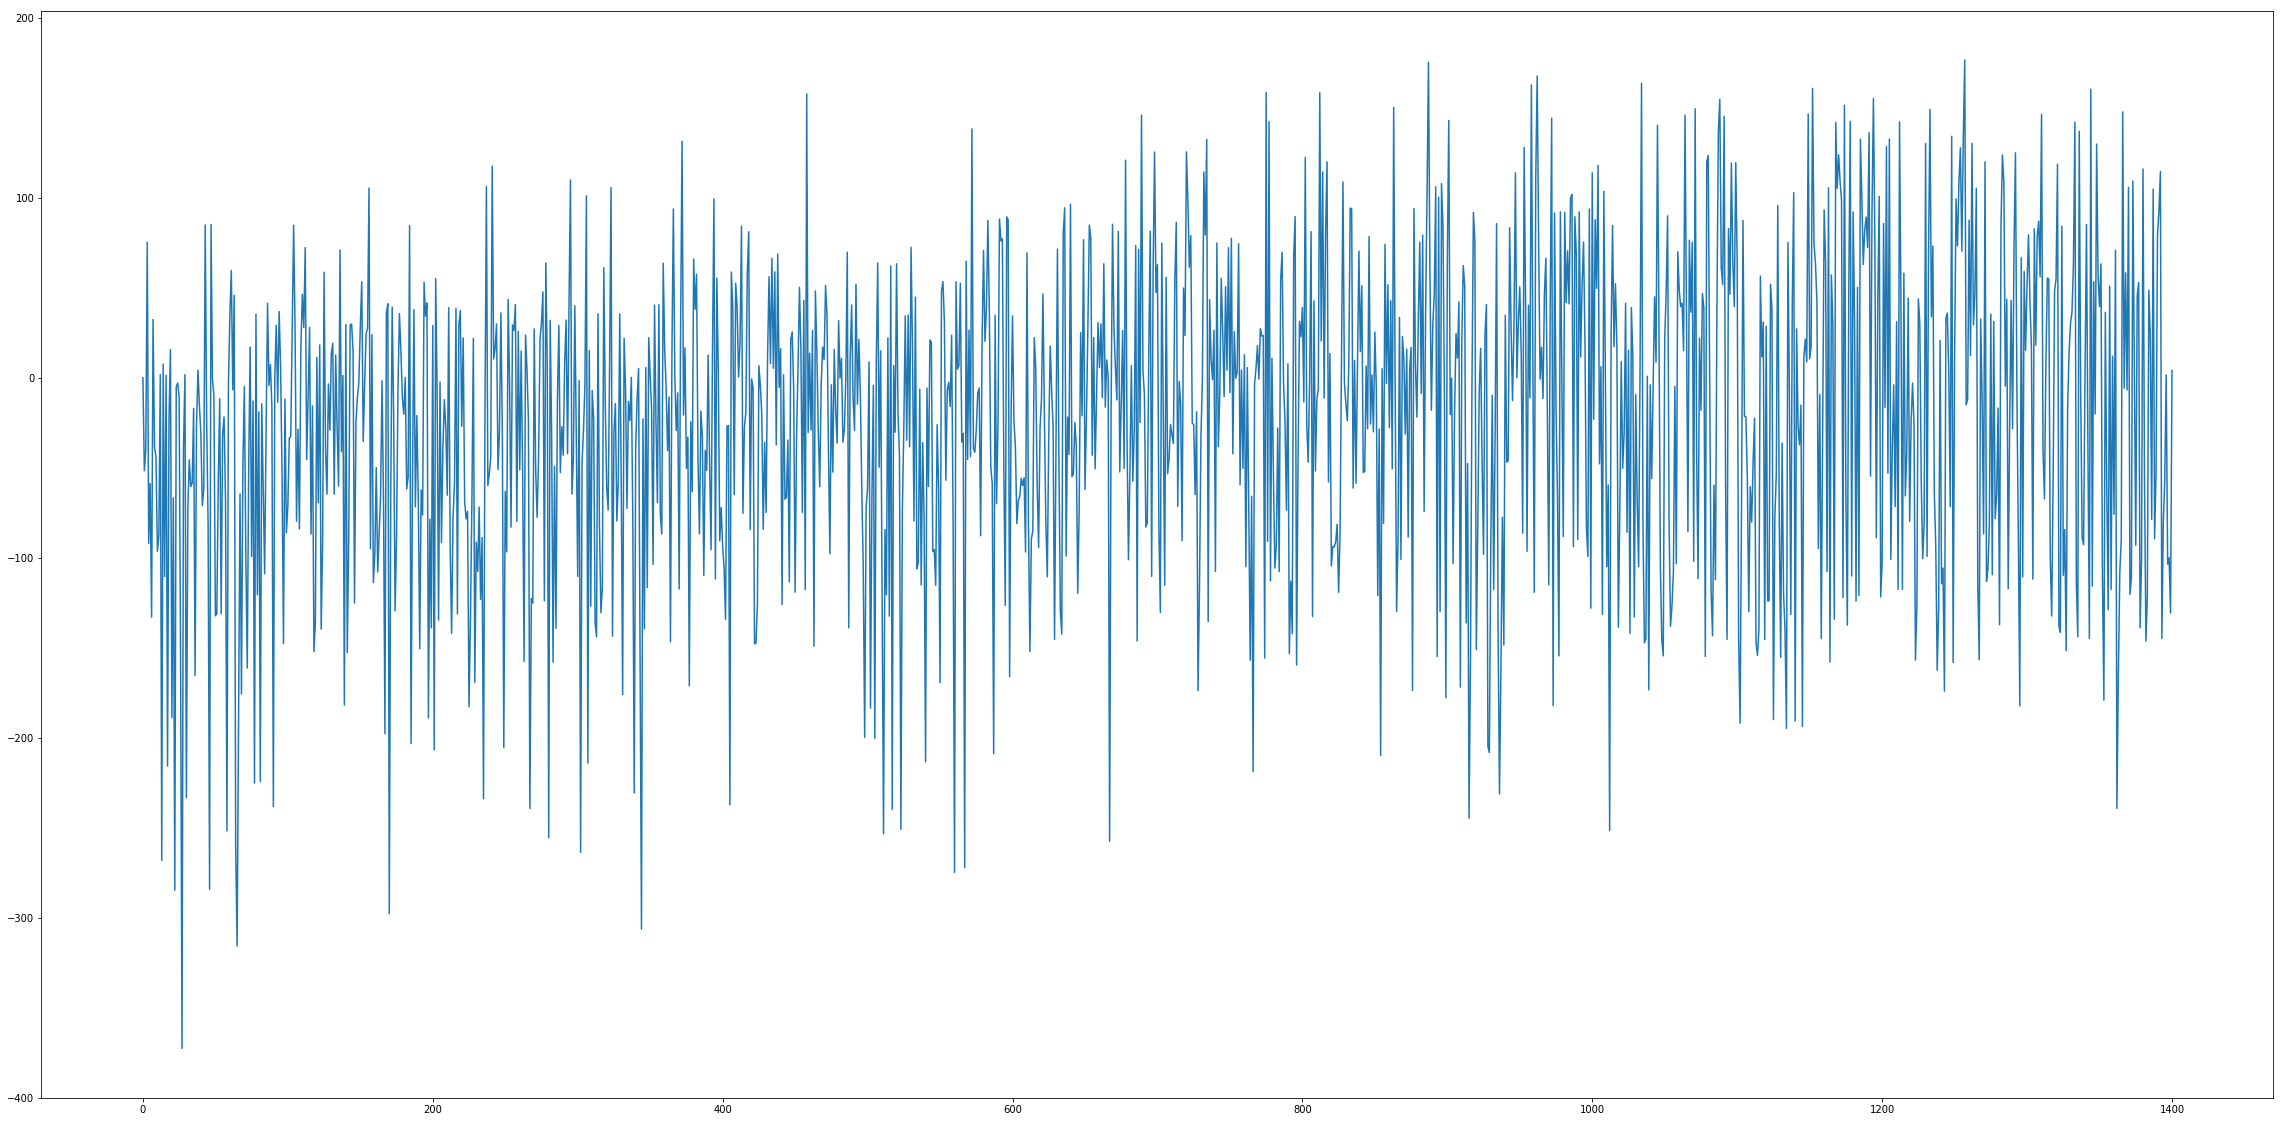

In [ ]:
done = False
batch_size = 30
game_history = [0]


explore = True
t_steps = 0
for episode in range(3000):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    start = time.time()
    for timee in range(450):

        action = agent.act(state)
        
        next_state, reward, done, _ = env.step(action)
        

        next_state = np.reshape(next_state, [1, state_size])

        agent.remember(state, action, reward, next_state, done)
        state = next_state
        
        if done:
            break
        
        total_reward += reward

    game_history.append(total_reward)
    
    if episode % 50 == 49:
        print("epi:{} score: {} mean:{} spent:{}".format(episode, total_reward, np.mean(game_history[-50:]), time.time() - start))
        agent.learn()
        agent.save_model()
        np.save("game_history", game_history)
        pl.figure(figsize=(40,20))
        pl.plot(game_history)
        display.clear_output(wait=True)
        display.display(pl.gcf())
